In [ ]:
!pip install transformers scikit-learn datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset,Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments,Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path='/content/drive/MyDrive/sentiment-analysis.csv'
df = pd.read_csv(dataset_path, header=None, names=["raw"], engine="python")

print(df.info())

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   raw     97 non-null     object
dtypes: object(1)
memory usage: 908.0+ bytes
None


In [ ]:
import pandas as pd
import re
from io import StringIO

column_name = df.columns[0]

def clean_before_split(text):
    if pd.isna(text):
        return ""
    text = str(text).strip()

    # 🔹 Remove leading and trailing triple quotes or single quotes
    text = re.sub(r'^[\'"]{2,}', '', text)
    text = re.sub(r'[\'"]{2,}$', '', text)

    # 🔹 Remove repeated double quotes inside ("" -> ")
    text = text.replace('""', '"')

    return text

# Apply cleaning
df[column_name] = df[column_name].apply(clean_before_split)

# ✅ Check one line after cleaning
print("Sample cleaned row:\n", df[column_name].iloc[0][:200], "\n")

# Step 2: Join text and read with pandas CSV parser
csv_like_text = '\n'.join(df[column_name].astype(str))

# 🔹 Now parse as real CSV
df_split = pd.read_csv(
    StringIO(csv_like_text),
    quotechar='"',
    skipinitialspace=True,
    header=None,
    engine='python'
)

# ✅ Check columns
print("Detected columns:", df_split.shape[1])

# Step 3: Rename columns if 7 found
if df_split.shape[1] == 7:
    df_split.columns = ['Text', 'Sentiment', 'Source', 'DateTime', 'UserID', 'Location', 'ConfidenceScore']
else:
    print(df_split.head(3))
    raise ValueError(f"Expected 7 columns, got {df_split.shape[1]}. Check input format again!")

# Step 4: Trim whitespace
for col in df_split.columns:
    if df_split[col].dtype == 'object':
        df_split[col] = df_split[col].str.strip()

print("\n✅ Final parsed data:")
print(df_split.head(3))


Sample cleaned row:
 Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score 

Detected columns: 7

✅ Final parsed data:
                        Text  Sentiment        Source             DateTime  \
0                       Text  Sentiment        Source            Date/Time   
1       I love this product!   Positive       Twitter  2023-06-15 09:23:14   
2  The service was terrible.   Negative  Yelp Reviews  2023-06-15 11:45:32   

     UserID     Location   ConfidenceScore  
0   User ID     Location  Confidence Score  
1  @user123     New York              0.85  
2   user456  Los Angeles              0.65  


In [ ]:
df_split['Sentiment'] = df_split['Sentiment'].str.strip().str.capitalize()
print(df_split['Sentiment'].value_counts())

sentiment_map = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df_split['label'] = df_split['Sentiment'].map(sentiment_map)


Sentiment
Positive     53
Negative     43
Sentiment     1
Name: count, dtype: int64


In [ ]:
# ==========================================
# ✅ FIXED DATA PREPROCESSING SECTION
# ==========================================

# Step 5: Data Preprocessing
def preprocess_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove quotes
    text = text.replace('"', '').replace("'", '').replace("`", '')

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply preprocessing
df['Text'] = df_split['Text'].apply(preprocess_text)

# Step 6: Handle Sentiment Labels
df['Sentiment'] = df_split['Sentiment'].str.strip().str.capitalize()

print("\n📊 Sentiment Distribution After Cleaning:")
print(df['Sentiment'].value_counts())
print("\nUnique sentiments:", df['Sentiment'].unique())

# ✅ Binary sentiment mapping
sentiment_map = {
    'Negative': 0,
    'Positive': 1
}
df['label'] = df['Sentiment'].map(sentiment_map)

# Check for unmapped values
print("\n🔍 Checking for unmapped sentiments:")
unmapped = df[df['label'].isna()]
if len(unmapped) > 0:
    print(f"⚠️ Found {len(unmapped)} unmapped rows:")
    print(unmapped[['Text', 'Sentiment']].head())
    df = df.dropna(subset=['label'])
    print(f"✅ Dropped unmapped rows. New shape: {df.shape}")

# ✅ Label sanity check
print("\n🧹 Label Sanity Check:")
print("Unique labels:", df['label'].unique())
print("Min label:", df['label'].min(), "Max label:", df['label'].max())
print("Data type:", df['label'].dtype)

# ✅ Fix legacy [0,2] labels → [0,1]
if sorted(df['label'].unique()) == [0, 2]:
    print("⚙️ Detected [0, 2] labels → remapping to [0, 1]")
    df['label'] = df['label'].replace({2: 1})

# Remove empty texts
df = df[df['Text'].str.len() > 0]
print(f"\n✅ Final dataset shape: {df.shape}")
print("\nFinal label distribution:")
print(df['label'].value_counts().sort_index())

# Step 7: Prepare for training
df_final = df[['Text', 'label']].copy()
df_final['label'] = df_final['label'].astype(int)

# Recalculate label info
unique_labels = sorted(df_final['label'].unique())
num_labels = len(unique_labels)
print(f"\n🎯 Number of classes: {num_labels}")
print("Unique labels:", unique_labels)

# Perform stratified split
try:
    train_df, val_df = train_test_split(
        df_final,
        test_size=0.2,
        random_state=42,
        stratify=df_final['label']
    )
    print(f"\n✅ Training samples: {len(train_df)}")
    print(f"✅ Validation samples: {len(val_df)}")
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts().sort_index())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts().sort_index())
except ValueError as e:
    print(f"\n⚠️ Stratified split failed: {e}")
    print("Performing random split without stratification...")
    train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)
    print(f"✅ Training samples: {len(train_df)}")
    print(f"✅ Validation samples: {len(val_df)}")

print("\n✅ Data ready for tokenization and model training")



📊 Sentiment Distribution After Cleaning:
Sentiment
Positive    53
Negative    43
Name: count, dtype: int64

Unique sentiments: ['Positive' 'Negative']

🔍 Checking for unmapped sentiments:

🧹 Label Sanity Check:
Unique labels: [1 0]
Min label: 0 Max label: 1
Data type: int64

✅ Final dataset shape: (96, 4)

Final label distribution:
label
0    43
1    53
Name: count, dtype: int64

🎯 Number of classes: 2
Unique labels: [np.int64(0), np.int64(1)]

✅ Training samples: 76
✅ Validation samples: 20

Training set distribution:
label
0    34
1    42
Name: count, dtype: int64

Validation set distribution:
label
0     9
1    11
Name: count, dtype: int64

✅ Data ready for tokenization and model training


In [ ]:
train_dataset = Dataset.from_pandas(train_df[['Text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['Text', 'label']].reset_index(drop=True))

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

In [ ]:
print(df['Sentiment'].value_counts())
print(df['label'].unique())


Sentiment
Positive    53
Negative    43
Name: count, dtype: int64
[1 0]


In [ ]:
model_checkpoint="bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['Text'],
        padding='max_length',
        truncation=True,
        max_length=128  # Adjust based on your text length
    )

# Apply tokenization to entire dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,  # only Positive & Negative
    id2label={0: 'Negative', 1: 'Positive'},
    label2id={'Negative': 0, 'Positive': 1}
)

print("✓ Model loaded successfully (Binary Sentiment)")
print(f"Model parameters: {model.num_parameters():,}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully (Binary Sentiment)
Model parameters: 109,483,778


In [ ]:
print("STEP 7: DEFINING EVALUATION METRICS")
# Load metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1']
    }
    print("✓ Metrics defined")


STEP 7: DEFINING EVALUATION METRICS


In [ ]:

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    report_to='none',  # Disable wandb
)
print("Training configuration:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Weight decay: {training_args.weight_decay}")

Training configuration:
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 2
  Weight decay: 0.01


In [ ]:
import numpy as np

print("Unique labels:", np.unique(tokenized_datasets['train']['label']))


Unique labels: [0 1]


In [ ]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
print("✓ Trainer created successfully")
# Train
train_result = trainer.train()

save_path = '/content/drive/MyDrive/fine_tuned_bert'
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"✓ Model saved to: {save_path}")

/tmp/ipython-input-163778489.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


✓ Trainer created successfully


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.576996,0.700000,0.657143
2,0.581300,0.480135,0.900000,0.897917


✓ Model saved to: /content/drive/MyDrive/fine_tuned_bert



STEP 12: DETAILED EVALUATION


Accuracy: 0.9000
F1-Score (weighted): 0.8979

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.78      0.88         9
    Positive       0.85      1.00      0.92        11

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20


✓ Confusion matrix saved to: /content/drive/MyDrive/confusion_matrix.png


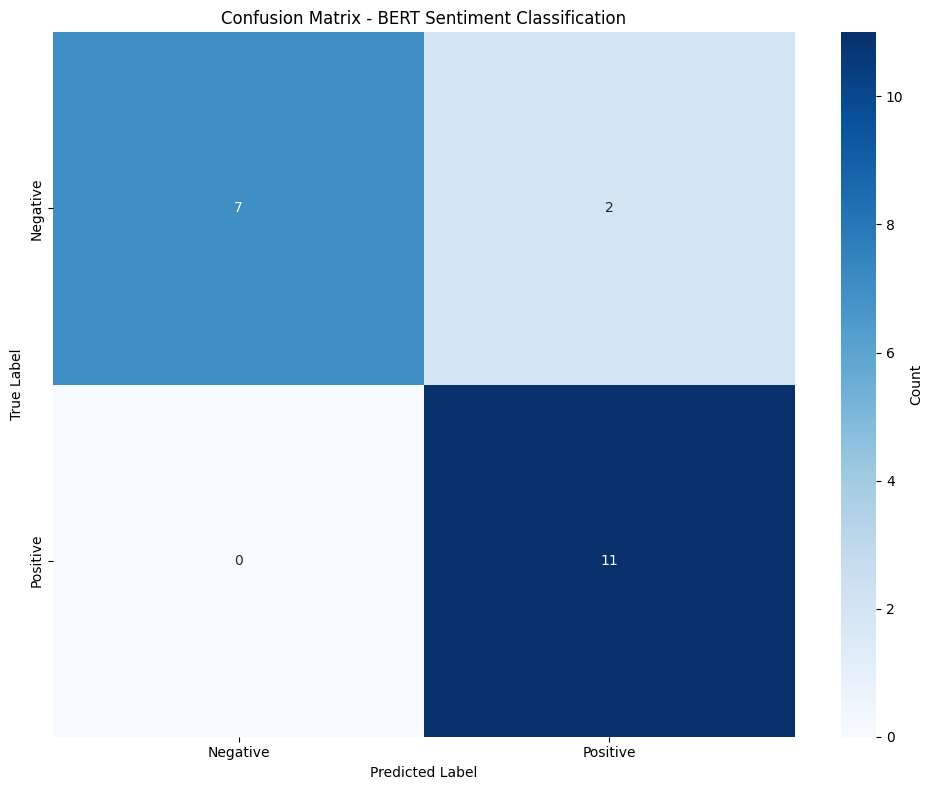


STEP 13: TESTING ON NEW EXAMPLES

Predictions on new examples:

Text: I love this product! It exceeded my expectations.
Predicted: Positive (confidence: 63.58%)

Text: The service was terrible and the staff was rude.
Predicted: Negative (confidence: 64.45%)

Text: It's okay, nothing special but not bad either.
Predicted: Positive (confidence: 50.05%)

Text: This is the best purchase I've ever made!
Predicted: Positive (confidence: 51.63%)

Text: Waste of money, very disappointing.
Predicted: Negative (confidence: 62.60%)

✓ FINE-TUNING COMPLETE!


In [ ]:
# ========================================
# 12. EVALUATION
# ========================================

print("\n" + "="*60)
print("STEP 12: DETAILED EVALUATION")
print("="*60)

# Get predictions
predictions = trainer.predict(tokenized_datasets['validation'])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

# Classification report
print("\nClassification Report:")
print("="*60)
from sklearn.utils.multiclass import unique_labels

# Automatically detect which labels are actually present
unique_classes = unique_labels(true_labels, pred_labels)

# Define all possible class names (only used for mapping)
all_class_names = {0: 'Negative', 1: 'Positive' }

# Keep only the ones that appear in the current dataset
target_names = [all_class_names[i] for i in unique_classes]

# Print the classification report safely
print(classification_report(true_labels, pred_labels, target_names=target_names))


# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names,
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - BERT Sentiment Classification')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved to: /content/drive/MyDrive/confusion_matrix.png")
plt.show()

# ========================================
# 13. TEST ON NEW EXAMPLES
# ========================================

print("\n" + "="*60)
print("STEP 13: TESTING ON NEW EXAMPLES")
print("="*60)

def predict_sentiment(text):
    """Predict sentiment for a new text"""
    # Preprocess
    text = preprocess_text(text)

    # Tokenize
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)

    # Move to same device as model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get prediction
    model.eval()
    import torch
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()

    sentiment_names = {0: 'Negative', 1: 'Positive'}

    return sentiment_names[predicted_class], confidence

# Test examples
test_texts = [

    "I love this product! It exceeded my expectations.",
    "The service was terrible and the staff was rude.",
    "It's okay, nothing special but not bad either.",
    "This is the best purchase I've ever made!",
    "Waste of money, very disappointing."
]

print("\nPredictions on new examples:")
print("="*60)
for text in test_texts:
    sentiment, confidence = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted: {sentiment} (confidence: {confidence:.2%})")

print("\n" + "="*60)
print("✓ FINE-TUNING COMPLETE!")
print("="*60)

In [ ]:
# ============================================================================
# COMPLETE STREAMLIT APP WITH NGROK - RUN THIS ENTIRE CELL IN GOOGLE COLAB
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Install required packages
print("📦 Installing required packages...")
!pip install streamlit pyngrok -q
print("✅ Packages installed!\n")

# Step 2: Create the Streamlit app
print("📝 Creating Streamlit app...")

app_code = '''import streamlit as st
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import re

st.set_page_config(page_title="Sentiment Analysis", page_icon="🎭", layout="wide")

st.markdown("""
<style>
    .main-header {font-size: 3rem; color: #1f77b4; text-align: center; margin-bottom: 2rem;}
    .sentiment-positive {background-color: #d4edda; padding: 1rem; border-radius: 10px; border-left: 5px solid #28a745;}
    .sentiment-negative {background-color: #f8d7da; padding: 1rem; border-radius: 10px; border-left: 5px solid #dc3545;}
    .confidence-score {font-size: 1.5rem; font-weight: bold;}
</style>
""", unsafe_allow_html=True)

@st.cache_resource
def load_model(model_path):
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        model.eval()
        return tokenizer, model
    except Exception as e:
        st.error(f"Error loading model: {str(e)}")
        return None, None

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.replace('"', '').replace("'", '').replace("`", '')
    text = text.lower()
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text)
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

def predict_sentiment(text, tokenizer, model):
    text = preprocess_text(text)
    if not text:
        return None, 0.0

    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()

    sentiment_names = {0: 'Negative', 1: 'Positive'}
    return sentiment_names[predicted_class], confidence

def main():
    st.markdown('<h1 class="main-header">🎭 Sentiment Analysis App</h1>', unsafe_allow_html=True)
    st.markdown("### Analyze the sentiment of text using fine-tuned BERT model")

    with st.sidebar:
        st.header("⚙️ Settings")
        model_path = st.text_input("Model Path", value="/content/drive/MyDrive/fine_tuned_bert")
        st.markdown("---")
        st.markdown("### About")
        st.info("This app uses a fine-tuned BERT model to classify text as **Positive** or **Negative**.")
        st.markdown("---")
        st.markdown("### Model Info")
        st.text("• Base: bert-base-uncased")
        st.text("• Classes: 2 (Positive/Negative)")
        st.text("• Max length: 128 tokens")

    with st.spinner("Loading model..."):
        tokenizer, model = load_model(model_path)

    if tokenizer is None or model is None:
        st.error("⚠️ Failed to load model. Please check the model path.")
        st.stop()

    st.success("✅ Model loaded successfully!")

    tab1, tab2 = st.tabs(["📝 Single Text", "📊 Batch Analysis"])

    with tab1:
        st.markdown("### Enter text to analyze")
        text_input = st.text_area("Text Input", height=150, placeholder="Type or paste your text here...")

        col1, col2, col3 = st.columns([1, 1, 2])
        with col1:
            analyze_button = st.button("🔍 Analyze", type="primary", use_container_width=True)
        with col2:
            clear_button = st.button("🗑️ Clear", use_container_width=True)

        if clear_button:
            st.rerun()

        if analyze_button and text_input:
            with st.spinner("Analyzing..."):
                sentiment, confidence = predict_sentiment(text_input, tokenizer, model)

                if sentiment:
                    st.markdown("---")
                    st.markdown("### Results")

                    if sentiment == "Positive":
                        st.markdown(f'<div class="sentiment-positive"><h2>😊 {sentiment}</h2><p class="confidence-score">Confidence: {confidence:.2%}</p></div>', unsafe_allow_html=True)
                    else:
                        st.markdown(f'<div class="sentiment-negative"><h2>😔 {sentiment}</h2><p class="confidence-score">Confidence: {confidence:.2%}</p></div>', unsafe_allow_html=True)

                    st.progress(confidence)

                    col1, col2 = st.columns(2)
                    with col1:
                        st.metric("Sentiment", sentiment)
                    with col2:
                        st.metric("Confidence", f"{confidence:.2%}")
                else:
                    st.warning("⚠️ Please enter valid text.")

        elif analyze_button:
            st.warning("⚠️ Please enter some text to analyze.")

        st.markdown("---")
        st.markdown("### Try these examples:")
        examples = [
            "I love this product! It exceeded my expectations.",
            "The service was terrible and the staff was rude.",
            "It's okay, nothing special but not bad either.",
            "This is the best purchase I've ever made!",
            "Waste of money, very disappointing."
        ]

        for idx, example in enumerate(examples):
            if st.button(f"📌 {example[:50]}...", key=f"ex_{idx}"):
                sentiment, confidence = predict_sentiment(example, tokenizer, model)
                st.info(f"**Sentiment:** {sentiment} | **Confidence:** {confidence:.2%}")

    with tab2:
        st.markdown("### Analyze multiple texts at once")
        uploaded_file = st.file_uploader("Upload CSV file", type=['csv'])

        if uploaded_file is not None:
            try:
                df = pd.read_csv(uploaded_file)
                text_columns = [col for col in df.columns if 'text' in col.lower()]

                if not text_columns:
                    st.error("⚠️ No 'text' column found in CSV.")
                else:
                    text_col = st.selectbox("Select text column:", text_columns)

                    if st.button("🔍 Analyze All", type="primary"):
                        with st.spinner("Analyzing all texts..."):
                            results = []
                            progress_bar = st.progress(0)

                            for idx, text in enumerate(df[text_col]):
                                sentiment, confidence = predict_sentiment(text, tokenizer, model)
                                results.append({
                                    'Text': text[:100] + '...' if len(str(text)) > 100 else text,
                                    'Sentiment': sentiment,
                                    'Confidence': f"{confidence:.2%}"
                                })
                                progress_bar.progress((idx + 1) / len(df))

                            results_df = pd.DataFrame(results)
                            st.markdown("### Results")
                            st.dataframe(results_df, use_container_width=True)

                            st.markdown("### Statistics")
                            col1, col2, col3 = st.columns(3)
                            positive_count = sum(1 for r in results if r['Sentiment'] == 'Positive')
                            negative_count = len(results) - positive_count

                            with col1:
                                st.metric("Total Texts", len(results))
                            with col2:
                                st.metric("Positive", positive_count)
                            with col3:
                                st.metric("Negative", negative_count)

                            csv = results_df.to_csv(index=False)
                            st.download_button("📥 Download Results", csv, "sentiment_results.csv", "text/csv")

            except Exception as e:
                st.error(f"Error processing file: {str(e)}")
        else:
            st.info("👆 Upload a CSV file to get started with batch analysis")

if __name__ == "__main__":
    main()
'''

# Save the app
with open('sentiment_app.py', 'w') as f:
    f.write(app_code)
print("✅ App created!\n")

# Step 3: Setup and run ngrok
print("🌐 Setting up ngrok...")
from pyngrok import ngrok
import subprocess
import time

# IMPORTANT: Set your ngrok auth token here
# Get it from: https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_TOKEN = "33kZw5OFReKJPYNySZFBwZ64Vur_83NfTSPwC2gJXeMh38CRm"  # Replace with your token

if NGROK_TOKEN == "YOUR_NGROK_AUTH_TOKEN_HERE":
    print("⚠️  WARNING: Please set your ngrok auth token!")
    print("   Get it from: https://dashboard.ngrok.com/get-started/your-authtoken")
    print("   Then update the NGROK_TOKEN variable above.\n")
else:
    ngrok.set_auth_token(NGROK_TOKEN)

# Kill any existing ngrok tunnels
ngrok.kill()

# Start Streamlit
print("🚀 Starting Streamlit app...")
process = subprocess.Popen(
    ["streamlit", "run", "sentiment_app.py", "--server.port", "8501", "--server.headless", "true"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for Streamlit to start
time.sleep(15)

# Create ngrok tunnel
public_url = ngrok.connect(8501)

print("\n" + "="*80)
print("✅ SUCCESS! Your Streamlit app is now running!")
print("="*80)
print(f"\n🌐 Public URL: {public_url}")
print(f"\n📱 Share this URL to access your app from anywhere!")
print("\n⚠️  IMPORTANT:")
print("   • Keep this cell running to maintain the connection")
print("   • Click 'Stop' on this cell to shut down the app")
print("   • The URL will change each time you restart")
print("\n" + "="*80 + "\n")

# Keep running
try:
    process.wait()
except KeyboardInterrupt:
    print("\n🛑 Shutting down...")
    process.kill()
    ngrok.kill()
    print("✅ App stopped successfully!")

Mounted at /content/drive
📦 Installing required packages...
✅ Packages installed!

📝 Creating Streamlit app...
✅ App created!

🌐 Setting up ngrok...
🚀 Starting Streamlit app...

✅ SUCCESS! Your Streamlit app is now running!

🌐 Public URL: NgrokTunnel: "https://mustachioed-superpiously-joycelyn.ngrok-free.dev" -> "http://localhost:8501"

📱 Share this URL to access your app from anywhere!

⚠️  IMPORTANT:
   • Keep this cell running to maintain the connection
   • Click 'Stop' on this cell to shut down the app
   • The URL will change each time you restart



🛑 Shutting down...
✅ App stopped successfully!
